In [36]:
# Exported functions and variables (not needed in notebook, but listed for clarity)
# initialize, initialize_original_thyrosim
# thyrosim, original_thyrosim, output_plot
# initialize!, set_patient_ic!, find_patient_ic!
# simulate
# fat_free_mass, adipose_tissue_free_mass

using CSV
using DelimitedFiles
using DifferentialEquations
using DataFrames
import Plots: plot, hline!, scatter!

In [ ]:
"""
initial conditions for new thyrosim model
"""
function initialize(
    dial::Vector{Float64} = [1.0; 0.88; 1.0; 0.88],
    scale_Vp::Bool = true,
    height=1.70,
    weight=70,
    sex=true; #true = male, false = female,
    fitting_index::Vector = Int[],         # needed in fitting
    p_being_optimized::Vector = Float64[], # needed in fitting
    fixed_parameters::Vector{Tuple{Int, Float64}}, # (a, b) means fix p[a] at b 
    scale_plasma_ode::Bool = true,
    scale_slow_ode::Bool = false,
    scale_fast_ode::Bool = false,
    scale_allometric_exponent::Bool = false,
    scale_clearance_by_gender::Bool = true,
    )

    # initial conditions
    ic    = zeros(Float64, 19)
    ic[1] = 0.322114215761171
    ic[2] = 0.201296960359917
    ic[3] = 0.638967411907560
    ic[4] = 0.00663104034826483
    ic[5] = 0.0112595761822961
    ic[6] = 0.0652960640300348
    ic[7] = 1.78829584764370
    ic[8] = 7.05727560072869
    ic[9] = 7.05714474742141
    ic[10] = 0
    ic[11] = 0
    ic[12] = 0
    ic[13] = 0
    ic[14] = 3.34289716182018
    ic[15] = 3.69277248068433
    ic[16] = 3.87942133769244
    ic[17] = 3.90061903207543
    ic[18] = 3.77875734283571
    ic[19] = 3.55364471589659

    # Parameter values
    p = zeros(Float64, 100)
    p[1] = 0.0027785399344 #S4 (fitted)
    p[2] = 8               #tau
    p[3] = 0.868           #k12
    p[4] = 0.108           #k13
    p[5] = 584             #k31free
    p[6] = 1503            #k21free
    p[7] = 0.000289        #A
    p[8] = 0.000214        #B
    p[9] = 0.000128        #C
    p[10] = -8.83*10^-6    #D
    p[11] = 0.88           #k4absorb; originally 0.881
    p[12] = 0.0189         #k02
    p[13] = 0.012101809339 #VmaxD1fast (fitted)
    p[14] = 2.85           #KmD1fast
    p[15] = 6.63*10^-4     #VmaxD1slow
    p[16] = 95             #KmD1slow
    p[17] = 0.00074619     #VmaxD2slow
    p[18] = 0.075          #KmD2slow
    p[19] = 3.3572*10^-4   #S3
    p[20] = 5.37           #k45
    p[21] = 0.0689         #k46
    p[22] = 127            #k64free
    p[23] = 2043           #k54free
    p[24] = 0.00395        #a
    p[25] = 0.00185        #b
    p[26] = 0.00061        #c
    p[27] = -0.000505      #d
    p[28] = 0.88           #k3absorb
    p[29] = 0.184972339613 #k05 (fitted)
    p[30] = 450            #Bzero (fixed so max TSH is about 1000)
    p[31] = 219.7085301388 #Azero (fitted)
    p[32] = 0              #Amax (set to 0 because 1976 weeke says hypothyroid patients should have no oscillations)
    p[33] = -3.71          #phi
    p[34] = 0.53           #kdegTSH-HYPO
    p[35] = 0.226          #VmaxTSH (originally it's 0.037 but this is probably a typo because eq4 of 2010 eigenberg it not a real hill function)
    p[36] = 23             #K50TSH
    p[37] = 0.058786935033 #k3 (fitted)
    p[38] = 0.29           #T4P-EU
    p[39] = 0.006          #T3P-EU
    p[40] = 0.037          #KdegT3B
    p[41] = 0.0034         #KLAG-HYPO
    p[42] = 5              #KLAG
    p[43] = 1.3            #k4dissolve
    p[44] = 0.12           #k4excrete; originally 0.119 (change with dial 2)
    p[45] = 1.78           #k3dissolve
    p[46] = 0.12           #k3excrete; originally 0.118 (change with dial 4)
    p[47] = 3.2            #Vp
    p[48] = 5.2            #VTSH 

    #parameters for hill functions in f_circ and SRtsh
    p[49] = 3.001011022378 #K_circ (fitted)
    p[50] = 3.094711690204 #K_SR_tsh (fitted)
    p[51] = 5.674773816316 #n, hill exponent in f_circ (fitted)
    p[52] = 6.290803221796 #m, hill exponent in SR_tsh (fitted)
    p[53] = 8.498343729591 #K_f4 for f4 (fitted)
    p[54] = 14.36664496926 #l, hill exponent for f4 (fitted)

    # p[55] = 0.0 # T4 oral dose
    # p[56] = 0.0 # T3 oral dose

    # dial parameters 
    p[57] = dial[1] # controls T4 secretion rate
    p[58] = dial[2] # controls T4 excretion rate
    p[59] = dial[3] # controls T3 secretion rate
    p[60] = dial[4] # controls T3 excretion rate

    # variance parameters for T4/T3/TSH and schneider error (these are used only for parameter estimation!)
    p[61] = 5.003761571969437   # σ for T4 in Blakesley (fixed to reasonable value before fitting)
    p[62] = 0.11122955089297369 # σ for T3 Blakesley and Jonklaas (fixed to reasonable value before fitting)
    p[63] = 0.4                 # σ for TSH in Blakesley and Jonklaas (fixed to reasonable value before fitting)
    p[64] = 0.1                 # σ for FT4 in Jonklaas (fixed to reasonable value before fitting)

    # Blakesley reference BMI
    p[65] = 21.82854404275587 # (male, fitted)
    p[66] = 22.99050845201536 # w / h^2 (female, fitted)

    # Vtsh scaling factor
    p[67] = 1.0 

    # extra parameter
    # p[68] = 22.5 # w / h^2 (female)

    # Volume scaling ratio
    p[69] = 1.0 # Plasma volume ratio
    p[70] = -1.0 # Plasma volume (forgot what this is supposed to represent)
    p[71] = 1.0 # allometric exponent for plasma volume

    # slow compartment scaling ratio
    p[72] = 1.0 # fat-free constant
    p[73] = 0.0 # fat constant
    p[74] = 1.0 # scaling ratio for slow compartment

    # fast compartment scaling ratio
    p[75] = 1.0

    # allometric exponent for k05 
    #p[76] = 0.75 # for male (fixed)
    #p[77] = 0.75 # for female (fixed, 0.75 works well)

    # ref height for male and female
    p[78] = 1.7608716659237555 # (fitted)
    p[79] = 1.6696106891941103 # (fitted)

    # clearance scale (male / female)
    p[80] = 1.0499391485135692 # male clearance (fitted)

    # infusion parameters
    p[81] = 0.0 # T4 infusion
    p[82] = 0.0 # T3 infusion

    # change fitting parameters
    if length(fitting_index) > 0
        p[fitting_index] .= p_being_optimized
    end

    # scale plasma parameters
    ref_bmi = sex ? p[65] : p[66]
    if scale_plasma_ode
        # for now, assume male and females have the same ref Vp (ie average male/female ref Vp)
        ref_Vp = (reference_Vp(ref_bmi, true, p[78]) + reference_Vp(ref_bmi, false, p[79])) / 2
        p[69] = predict_Vp(height, weight, sex) / ref_Vp
    end
    scale_allometric_exponent && (p[71] = 0.75)

    # scale slow compartment
    if scale_slow_ode
        ref_weight = sex ? p[65] * p[78]^2 : p[66] * p[79]^2
        ref_fat_free_mass = reference_fat_free_mass(sex, male_ref_height=p[78], female_ref_height=p[79])
        ref_fat_mass = ref_weight - ref_fat_free_mass
        slow_compartment_scale = (p[72] * fat_free_mass(sex, height) + p[73] * (weight - fat_free_mass(sex, height))) / 
            (p[72] * ref_fat_free_mass + p[73] * ref_fat_mass)
        p[74] = slow_compartment_scale
    end

    # scale fast compartment
    scale_fast_ode && (p[75] = 1.0)

    if scale_Vp
        Vp, Vtsh = plasma_volume(height, weight, sex, p[67], ref_bmi, p[78], p[79])
        p[47] = Vp
        p[48] = Vtsh
    end

    
    # Eliminated allometric scaling of K05 - Katarina
    
    #clearance_allometric_exp = sex ? p[76] : p[77]
    #if scale_clearance_by_gender
        #ref_weight = sex ? p[65] * p[78]^2 : p[66] * p[79]^2
    #else
        #ref_weight = (p[65] * p[78]^2 + p[66] * p[79]^2) / 2
    #end
    #p[29] *= (weight / ref_weight)^clearance_allometric_exp
    
    
    
    # Making K05 a function of sex - Katarina
    p29_original = p[29]

    if sex  # male
        p[29] = p29_original * p[80]
    else    # female
        p[29] = p29_original
    end


    

    # fix parameters declared by users
    for (a, b) in fixed_parameters
        p[a] = b
    end


    return ic, p, p[48]  # return Vtsh explicitly
end

"""
    plasma_volume(height, weight, sex, p)

# Parameters used to get reference plasma volume (Vp) values:
## MCL: NEED TO DOUBLE-CHECK HEIGHT/WEIGHT
## Blakesley data: half male, half female all of "normal weight and height" (but no values given in paper).
## height: Average height in USA.
## weight: I think we used approximate values from back-transforming it from BMI = 22.5?
    male_height   = 1.70
    female_height = 1.63
    male_weight   = 70.0
    female_weight = 59.0

The transform equation is `Vp_new = 3.2 * Vp_predicted / Vp_ref` where `Vp_ref` is 
the predicted Vp for the reference male/female patients. Thus, a reference
patient would have Vp_new = 3.2.

# Inputs
+ `h`: height measured in meters
+ `w`: weight measured in KG 
+ `sex`: true = male, false = female

# Optional inputs
+ `male_ref_vp`: male reference Vp
+ `female_ref_vp`: female reference Vp

# Outputs 
+ `Vp_new`: Scaled plasma volume (liters)
+ `Vtsh_new`: Scaled TSH distribution volume (liters)
"""
function plasma_volume(h, w, sex::Bool,
    Vtsh_scale = 1.0, ref_bmi = 22.5,
    male_ref_height = 1.7, female_ref_height=1.63
    )
    # for now, assume male and females have the same ref Vp (ie average male/female ref Vp)
    ref_Vp = (reference_Vp(ref_bmi, true, male_ref_height) + reference_Vp(ref_bmi, false, female_ref_height)) / 2
    Vp_new = predict_Vp(h, w, sex) * 3.2 / ref_Vp

    # scale Vtsh according to Vtsh_new = Vtsh_old + c(Vp_new - Vp_old) 
    Vtsh_new = 5.2 + Vtsh_scale * (Vp_new - 3.2)  # changed 5.2 to Vtsh= = p[48] - KATARINA 08/18/25

    return Vp_new, Vtsh_new
end

"""
    reference_Vp(ref_BMI::Float64, sex::Bool)

Calculates the "reference plasma volume" for Blakesleys patients with specified

Since the predicted plasma volume from Feldschush's data is not 3.2, this
reference volume is used to scale the predicted volume to 3.2. 
"""
function reference_Vp(ref_BMI::Float64, sex::Bool, ref_height::Float64)
    # calculate weight for specified ref_BMI. Ideal weight (iw) is fitted to Feldschush's data
    if sex
        iw = 176.3 - 220.6 * ref_height + 93.5 * ref_height^2
    else
        iw = 145.8 - 182.7 * ref_height + 79.55 * ref_height^2
    end
    w = ref_BMI * ref_height^2

    return predict_Vp(ref_height, w, sex)
end

"""
    predict_Vp(h, w, sex::Bool)

Computes the predicted plasma volume based on data fitted to Feldchush's data

# Inputs
+ `h`: height measured in meters
+ `w`: weight measured in KG 
+ `sex`: true = male, false = female
"""
#function predict_Vp(h, w, sex::Bool) # BEN - REDONE below on 08/18/25 by KATARINA
    # hematocrit level, set to .45 for male and .4 for females
    #Hem = 0.40 + 0.05 * sex

    # calculate Ideal Weight fitted to Feldschush's data
    #if sex == 1
       # iw = 176.3 - 220.6 * h + 93.5 * h^2
    #elseif sex == 0
       # iw = 145.8 - 182.7 * h + 79.55 * h^2
   # end

    # power law fitted to Feldchush data 
   # a, n = 1.26975706e+03, 3.72981228e-01
   # Δiw = (w - iw) / iw * 100  #deviation from ideal weight, in percentage
    #Vb_per_kg = a * (100.0 + Δiw)^(n - 1)  # BEN
    
   # Vb = Vb_per_kg * w / 1000
    
   # return Vb * (1 - Hem)
#end


# new fit equations - KATARINA 08/18/25
#Vb_per_kg_male = 71.96 * exp(-0.007516 * Δiw)
#Vb_per_kg_female = 43.65 + 20.79 * exp(-0.01545 * Δiw) + 2.043 * exp(-0.08392 * Δiw)



function predict_Vp(h, w, sex::Bool)  # KATARINA 08/18/25
    # Hematocrit level: 0.45 for male, 0.40 for female
    Hem = 0.40 + 0.05 * sex

    if sex == 1
       iw = 176.3 - 220.6 * h + 93.5 * h^2
    elseif sex == 0
       iw = 145.8 - 182.7 * h + 79.55 * h^2
    end

    # Percent deviation from ideal weight
    Δiw = (w - iw) / iw * 100

    
    if sex == 1
       Vb_per_kg = 71.96 * exp(-0.007516 * Δiw)
    elseif sex == 0
       Vb_per_kg = 43.65 + 20.79 * exp(-0.01545 * Δiw) + 2.043 * exp(-0.08392 * Δiw)
    end

    # Compute total blood volume in liters
    Vb = Vb_per_kg * w / 1000

    # Return plasma volume (liters)
    return Vb * (1 - Hem)
end






# this next blood_volume function paragraph seems to be redundant to predict_Vp - Katarina and Joe

#function blood_volume(h, w, sex::Bool) # BEN - redone below on 08/18/25 by KATARINA
   # Hem = 0.40 + 0.05 * sex #.45 for male and .4 for females (by default)
   # BMI = w / h^2

    # calculate Ideal Weight fitted to Feldschush's data
   # if sex == 1
   #     iw = 176.3 - 220.6 * h + 93.5 * h^2
   # elseif sex == 0
   #     iw = 145.8 - 182.7 * h + 79.55 * h^2
   # end

    # power law fitted to Feldchush data
   # a, n = 1.26975706e+03, 3.72981228e-01
   # Δiw = (w - iw) / iw * 100  #deviation from ideal weight, in percentage
    # Vb_per_kg = a * (100.0 + Δiw)^(n - 1) # BEN
   # Vb_per_kg = 44.18 + 19.88 * exp(-0.015 * Δiw) + 1.82 * exp(-0.121 * Δiw) # KATARINA 
   # return Vb_per_kg * w / 1000
#end



function blood_volume(h, w, sex::Bool) # KATARINA 08/18/25
    Hem = 0.40 + 0.05 * sex  # 0.45 for males, 0.40 for females by default
    BMI = w / h^2

    if sex == 1
        iw = 176.3 - 220.6 * h + 93.5 * h^2
    elseif sex == 0
        iw = 145.8 - 182.7 * h + 79.55 * h^2
    end

    # % deviation from ideal weight
    Δiw = (w - iw) / iw * 100

    # Use refit sex-specific blood volume per kg
    if sex == 1
       Vb_per_kg = 71.96 * exp(-0.007516 * Δiw)
    elseif sex == 0
       Vb_per_kg = 43.65 + 20.79 * exp(-0.01545 * Δiw) + 2.043 * exp(-0.08392 * Δiw)
    end

    println("Ideal Weight (iw): ", round(iw, digits=2), " kg")  
    
    # Return blood volume in liters
    return Vb_per_kg * w / 1000
end





"""
ODEs for latest thyrosim model. 
"""
function thyrosim(dq, q, p, t)
    kdelay = 5/8

    # scaling the mass/concentration of compartments
    plasma_volume_ratio = p[69]^p[71]
    slow_volume_ratio = p[74]^p[71]
    fast_volume_ratio = p[75]^p[71]

    # scale comparment sizes
    q1 = q[1] * 1 / p[69]
    q2 = q[2] * 1 / p[75]
    q3 = q[3] * 1 / p[74]
    q4 = q[4] * 1 / p[69]
    q5 = q[5] * 1 / p[75]
    q6 = q[6] * 1 / p[74]
    q7 = q[7] * 1 / p[69]

    # adhoc fix for https://github.com/biona001/Thyrosim.jl/issues/1
    q[findall(x -> x < 0, q)] .= 0

    # Auxillary equations
    q4F = (p[24]+ p[25] * q1 + p[26] * q1^2 + p[27] * q1^3) * q4 #FT3p
    q1F = (p[7] + p[8] * q1 + p[9] * q1^2 + p[10] * q1^3) * q1  #FT4p
    SR3 = (p[19] * p[59] * q[19])                                        #Brain delay (dial 3)
    SR4 = (p[1] * p[57] * q[19])                                         #Brain delay (dial 1)
    fCIRC = q[9]^p[51] / (q[9]^p[51] + p[49]^p[51])
    SRTSH = (p[30]+p[31]*fCIRC*sin(pi/12*t-p[33]))*(p[50]^p[52]/(p[50]^p[52] + q[9]^p[52]))
    fdegTSH = p[34] + p[35] / (p[36] + q7)
    fLAG = p[41] + 2*q[8]^11 / (p[42]^11 + q[8]^11)
    f4 = p[37]*(1 + 5*(p[53]^p[54]) / (p[53]^p[54]+q[8]^p[54]))
    NL = p[13] / (p[14] + q2)

    # ODEs
    dq[1]  = p[81] + (SR4 + p[3] * q2 + p[4] * q3 - (p[5] + p[6]) * q1F) * plasma_volume_ratio + p[11] * q[11] #T4dot (need to remove u1)
    dq[2]  = (p[6] * q1F - (p[3] + p[12] + NL) * q2) * fast_volume_ratio                                    #T4fast
    dq[3]  = (p[5] * q1F -(p[4] + p[15] / (p[16] + q3) + p[17] /(p[18] + q3)) * q3) * slow_volume_ratio  #T4slow
    dq[4]  = p[82] + (SR3 + p[20] * q5 + p[21] * q6 - (p[22] + p[23]) * q4F) * plasma_volume_ratio + p[28] * q[13] #T3pdot
    dq[5]  = (p[23] * q4F + NL * q2 - (p[20] + p[29]) * q5) * fast_volume_ratio                         #T3fast
    dq[6]  = (p[22] * q4F + p[15] * q3 / (p[16] + q3) + p[17] * q3 / (p[18] + q3) -(p[21])*q6) * slow_volume_ratio #T3slow
    dq[7]  = (SRTSH - fdegTSH * q7) * plasma_volume_ratio                                           #TSHp
    dq[8]  = f4 / p[38] * q1 + p[37] / p[39] * q4 - p[40] * q[8]          #T3B
    dq[9]  = fLAG * (q[8] - q[9])                                             #T3B LAG
    dq[10] = -p[43] * q[10]                                                   #T4PILLdot
    dq[11] =  p[43] * q[10] - (p[44] * p[58]+ p[11]) * q[11]                  #T4GUTdot: note p[44] * p[58] = p[44] * dial[2] = k4excrete
    dq[12] = -p[45] * q[12]                                                   #T3PILLdot
    dq[13] =  p[45] * q[12] - (p[46] * p[60] + p[28]) * q[13]                 #T3GUTdot: note p[46] * p[60] = p[46] * dial[4] = k3excrete

    # Delay ODEs
    dq[14] = kdelay * (q7 - q[14]) 
    dq[15] = kdelay * (q[14] - q[15])                                         #delay2
    dq[16] = kdelay * (q[15] - q[16])                                         #delay3
    dq[17] = kdelay * (q[16] - q[17])                                         #delay4
    dq[18] = kdelay * (q[17] - q[18])                                         #delay5
    dq[19] = kdelay * (q[18] - q[19])                                         #delay6
end

function output_equations(sol, p)
    return [777.0 * sol[1, :] / p[47], #T4
            651.0 * sol[4, :] / p[47], #T3
            5.6 * sol[7, :] / p[48]] #TSH
end

"""
Set initial conditions from data. Options to set other compartments to steady state,
optionally including the TSH lag compartments.
"""
function set_patient_ic!(ic, p, t4, t3, tsh;
        steady_state::Bool=false, set_tsh_lag::Bool=false)
    # Set IC for observed compartments. 
    ic[1] = (p[47] * t4) / 777.0
    ic[4] = (p[47] * t3) / 651.0
    ic[7] = (p[48] * tsh) / 5.6
    
    if steady_state
        q4F = (p[24]+ p[25] * ic[1] + p[26] * ic[1]^2 + p[27] *ic[1]^3) * ic[4] #FT3p
        q1F = (p[7] + p[8] * ic[1] + p[9] * ic[1]^2 + p[10] * ic[1]^3) * ic[1]  #FT4p
        
        B = p[6] * q1F - p[14] * (p[3] + p[12]) - p[13]
        A = -(p[3] + p[12])
        C = p[6] * p[14] * q1F
        ic[2] = (-B - sqrt(B^2 - 4.0 * A *C)) / (2.0 * A)
        
        B = p[5] * q1F - (p[4] + p[15] / p[16]) * p[18] - p[17]
        A = -(p[4] + p[15] / p[16])
        C = p[5] * p[18] * q1F
        ic[3] = (-B - sqrt(B^2 - 4.0 * A *C)) / (2.0 * A)
        
        ic[5] = (p[23] * q4F + (p[13] / (p[14] + ic[2])) * ic[2]) / (p[20] + p[29])
        ic[6] = (p[22] * q4F + p[15] * (ic[3] / (p[16] + ic[3]))
            + p[17] * (ic[3] / (p[18] + ic[3]))) / p[21]
    end
    
    if set_tsh_lag
        # Probably not 100% corect since they're supposed to be lagged, but probably better than the default.
        ic[14:19] .= ic[7]
    end
end

"""
Find initial conditions from approximate steady state solution. 

This function runs a Thyrosim simulation for 30 days and sets the initial 
contidion `ic` to the ending values for each compartment.
"""
function find_patient_ic!(ic, p, days, model = thyrosim)
    tspan = (0.0, 24.0 * days)
    prob = ODEProblem(model, ic, tspan, p)
    sol = solve(prob)
    ic .= sol[end]
end

# Figure 2 of Heymsfield 2007: https://academic.oup.com/ajcn/article/86/1/82/4633194
function adipose_tissue_free_mass(sex::Bool, h::Real) #true = male, false = female, height h in meter
    h_cm = 100h
    sex ? 0.0006 * h_cm^2.21 : 0.001 * h_cm^2.1 # unit kg
end

# Figure 3 of Heymsfield 2007: https://academic.oup.com/ajcn/article/86/1/82/4633194
function fat_free_mass(sex::Bool, h::Real) #true = male, false = female, height h in meter
    h_cm = 100h
    sex ? 0.0004 * h_cm^2.3 : 0.0019 * h_cm^1.97 # unit kg
end

function reference_fat_free_mass(sex::Bool; male_ref_height=1.7, female_ref_height=1.63)
    h = sex ? male_ref_height : female_ref_height # avg male/female height
    return fat_free_mass(sex, h) # unit kg
end

# Table 2 of Muler 2011: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0022732
function liver(w::Real, h::Real) # w in kg, h in meter
    return 0.088 * w^0.54 * h^1.04
end

function kidney(w::Real, h::Real)
    return 0.012 * w^0.72 * h^0.19
end

kidney (generic function with 1 method)

In [272]:
"""
    simulate(h, w, sex, ...)

Simulate a person of known height, weight, and gender for 30 days (default).

If `warmup = true`, will first run the model for 30 days, assuming healthy
thyroid function, to get approximate initial condition. 

Note: The last 5 parameters are optional scaling parameters, but in our final model,
only `scale_plasma_ode` and `scale_clearance_by_gender` are set to `true`. Thus only 
these 2 are true by default. 
"""
function simulate(
    h::Real, # units meters
    w::Real, # units kg
    sex::Bool; # true = male, false = female
    days::Int=30, 
    dial=[1.0; 0.88; 1.0; 0.88], 
    T4dose::Real=0.0, # mcgs
    T3dose::Real=0.0, # mcgs
    dosing_interval::Real=24.0, #hours
    warmup::Bool = true,
    fitting_index = Int[],
    parameters = Float64[],
    fixed_parameters=Tuple{Int64,Float64}[],
    scale_plasma_ode=true,
    scale_slow_ode=false,
    scale_fast_ode=false,
    scale_allometric_exponent = false,
    scale_clearance_by_gender = true,
    )
    function add_dose!(integrator)
        integrator.u[10] += integrator.p[55]
        integrator.u[12] += integrator.p[56]
    end
    cbk = PeriodicCallback(add_dose!, dosing_interval) 

    # initialize thyrosim parameters
    ic, p = initialize(dial, true, h, w, sex, 
        fitting_index=fitting_index, p_being_optimized=parameters,
        fixed_parameters=fixed_parameters,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode,
        scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
    p[fitting_index] .= parameters

    # run simulation for 30 days to get approximate steady state conditions
    # this assumes healthy patient without dose
    warmup && find_patient_ic!(ic, p, 30) 

    # setup daily dosing and fitting parameters 
    p[55] = T4dose / 777.0 # daily dose
    p[56] = T3dose / 651.0 # daily dose
    p[57:60] .= dial #set dial

    # solve and return ode solution
    prob = ODEProblem(thyrosim,ic,(0.0, 24days),p,callback=cbk)
    return solve(prob, Rodas5())
end

simulate

In [1765]:
using Plots
using DifferentialEquations

# KATARINA - created dosing plot functions for either FT4/FT3/TSH, FT4/TT3/TSH or TT4/TT3/TSH

function dosing_plots_FT4_FT3_TSH(sol; title::AbstractString = "Thyrosim simulation", automargins::Bool=true)
    p = sol.prob.p
    
    # Correct conversion equations
    T4 = sol[1,:]
    T3 = sol[4,:]
    
    # FT4 and FT3 are slightly adjusted upwards for changes in assay methods over the last several decades.
    # Mean values adjusted to the middle of 2025 normal clinical lab ranges. - KAT/JOE 
    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    FT3 = 1.05 * 0.5 * (0.00395 .+ 0.00185 .* T4 .+ 0.00061 .* T4.^2 .+ 0.000505 .* T4.^3) .* T3

    FT4_units = 1000 * 777 .* FT4 ./ p[47]      # ng/L
    FT3_units = 1000 * 651 .* FT3 ./ p[47]      # ng/L
    TSH = 5.6 * sol[7, :] / p[48]
    
    if automargins
        ft4lim = max(1.2 * maximum(FT4), 2)
        ft3lim = max(1.2 * maximum(FT3), 0.0044)
        tshlim = max(1.2 * maximum(TSH), 5.5)
    end

    p1 = plot(sol.t / 24.0, FT4_units, ylabel="FT4 (ng/L)", title=title, linewidth=2, legend=false)
    p1 = hline!([8, 18])

    p2 = plot(sol.t / 24.0, FT3_units, ylabel="FT3 (ng/L)", linewidth=2, legend=false)
    p2 = hline!([2.25, 4])

    p3 = plot(sol.t / 24.0, TSH, ylabel="TSH (mU/L)", xlabel="Days", linewidth=2, legend=false)
    p3 = hline!([0.4, 4.0])

    plot(p1, p2, p3, layout=(3, 1))
end

    
function dosing_plots_FT4_TT3_TSH(sol; title::AbstractString = "Thyrosim simulation", automargins::Bool=true)
    p = sol.prob.p
    T4 = sol[1, :]
    T3 = sol[4, :]
    TSH = 5.6 * sol[7, :] / p[48]

    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    FT4_units = 1000 * 777 .* FT4 ./ p[47]
    TT3 = 651.0 * T3 ./ p[47]

    ft4lim, tt3lim, tshlim = 25.0, 3.0, 10.0
    if automargins
        ft4lim = max(1.2 * maximum(FT4_units), 18)
        tt3lim = max(1.2 * maximum(TT3), 2.0)
        tshlim = max(1.2 * maximum(TSH), 5.5)
    end

    p1 = plot(sol.t / 24.0, FT4_units, ylabel="FT4 (ng/L)", title=title, linewidth=2, legend=false)
    p1 = hline!([8, 18])

    p2 = plot(sol.t / 24.0, TT3, ylim=(0, tt3lim), ylabel="TT3 (µg/L)", linewidth=2, legend=false)
    p2 = hline!([0.6, 1.8])

    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), ylabel="TSH (mU/L)", xlabel="Days", linewidth=2, legend=false)
    p3 = hline!([0.45, 4.5])

    plot(p1, p2, p3, layout=(3, 1))
end


function dosing_plots_TT4_TT3_TSH(sol; title::AbstractString = "Thyrosim simulation", automargins::Bool=true)
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 140, 4, 10
    T4 = 777.0 * sol[1, :] / p[47]
    T3 = 651.0 * sol[4, :] / p[47]
    TSH = 5.6 * sol[7, :] / p[48]
    
    if automargins
        t4lim = max(1.2 * maximum(T4), 130.0)
        t3lim = max(1.2 * maximum(T3), 2.5)
        tshlim = max(1.2 * maximum(TSH), 5.5)
    end

    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), ylabel="T4 (µg/L)", title=title, linewidth=2, legend=false)
    p1 = hline!([45, 120])

    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), ylabel="T3 (µg/L)", linewidth=2, legend=false)
    p2 = hline!([0.6, 1.8])

    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), ylabel="TSH (mU/L)", xlabel="Days", linewidth=2, legend=false)
    p3 = hline!([0.45, 4.5])

    plot(p1, p2, p3, layout=(3, 1))
end


dosing_plots_TT4_TT3_TSH (generic function with 1 method)

In [1766]:
# Conversion functions
function inches_to_meters(inches)
    return inches * 0.0254
end

function pounds_to_kilograms(pounds)
    return pounds * 0.453592
end
  
    
# New function that allows for 24 hour dosing intervals of LT4 and 12 hour dosing intervals of LT3
function simulate_dosing_intervals(
    h::Real, w::Real, sex::Bool;
    days::Int=30, 
    dial=[1.0; 0.88; 1.0; 0.88], 
    T4dose::Real=0.0, 
    T3dose::Real=0.0, 
    warmup::Bool=true,
    fitting_index=Int[],
    parameters=Float64[],
    fixed_parameters=Tuple{Int64,Float64}[],
    scale_plasma_ode=true,
    scale_slow_ode=false,
    scale_fast_ode=false,
    scale_allometric_exponent=false,
    scale_clearance_by_gender=true,
)
    # Callback to add LT4 every 24 hours
    function add_LT4!(integrator)
        integrator.u[10] += integrator.p[55]
    end
    cbk_LT4 = PeriodicCallback(add_LT4!, 24.0)

    # Callback to add LT3 every 12 hours
    function add_LT3!(integrator)
        integrator.u[12] += integrator.p[56]
    end
    cbk_LT3 = PeriodicCallback(add_LT3!, 12.0)

    # Initialize
    ic, p = initialize(dial, true, h, w, sex, fitting_index=fitting_index, p_being_optimized=parameters,
        fixed_parameters=fixed_parameters, scale_plasma_ode=scale_plasma_ode, 
        scale_slow_ode=scale_slow_ode, scale_fast_ode=scale_fast_ode, 
        scale_allometric_exponent=scale_allometric_exponent, scale_clearance_by_gender=scale_clearance_by_gender)
    p[fitting_index] .= parameters

    warmup && find_patient_ic!(ic, p, 30)

    p[55] = T4dose / 777.0  
    p[56] = T3dose / 651.0  
    p[57:60] .= dial  

    # Create the problem with both callbacks in a CallbackSet
    prob = ODEProblem(thyrosim, ic, (0.0, days*24), p, callback=CallbackSet(cbk_LT4, cbk_LT3))

    return solve(prob)
end


simulate_dosing_intervals (generic function with 1 method)

# Generate Plots

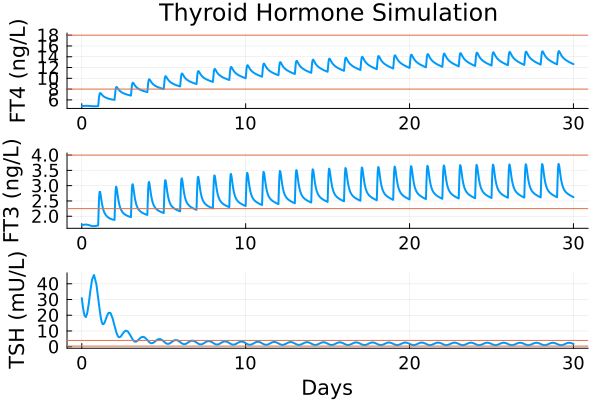

In [1767]:
# Example 1: Female, 67 in, 120 lbs, RTF = 2.5%, given LT4 dose of 100 µg and 7.5 µg LT3 every 24 hours
# Plotted on FT4, FT3, TSH plots

# === INPUTS (Imperial units) ===
sex = false                 # true = Male, false = Female
h_in = 67                   # Height in inches
w_lb = 120                  # Weight in pounds
T4dose = 100               # LT4 dose in µg
T3dose = 7.5                  # LT3 dose in µg
RTF = 0.025                 # Residual thyroid function (0–1)
dial = [RTF; 0.88; RTF; 0.88] # Thyroid secretion rates (stays constant)

# === Convert to metric units ===
h_m = inches_to_meters(h_in)
w_kg = pounds_to_kilograms(w_lb)

# === RUN SIMULATION ===
# 24-hr dosing intervals of LT4 + LT3
sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose)

# 24-hr dosing interval of LT4 and 12-hr dosing interval of LT3
#sol = simulate_dosing_intervals(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose) 


# === PLOT RESULTS ===
plt = dosing_plots_FT4_FT3_TSH(sol, title="Thyroid Hormone Simulation") # Plots FT4, FT3, TSH
#plt = dosing_plots_FT4_TT3_TSH(sol, title="Thyroid Hormone Simulation") # Plots FT4, TT3, TSH
#plt = dosing_plots_TT4_TT3_TSH(sol, title="Thyroid Hormone Simulation") # Plots TT4, TT3, TSH


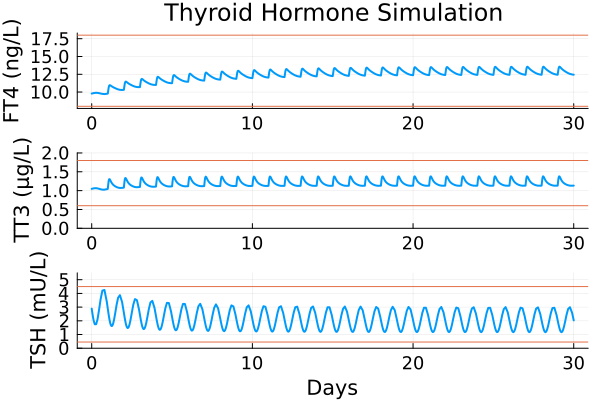

In [1768]:
# Example 2: Male, 70 in, 160 lbs, RTF = 50%, given LT4 dose of 50 µg and 5 µg LT3 every 24 hours
# Plotted on FT4, TT3, TSH plots

# === INPUTS (Imperial units) ===
sex = true                  # true = Male, false = Female
h_in = 70                   # Height in inches
w_lb = 160                  # Weight in pounds
T4dose = 50                 # LT4 dose in µg
T3dose = 5                  # LT3 dose in µg
RTF = 0.5                   # Residual thyroid function (0–1)
dial = [RTF; 0.88; RTF; 0.88] # Thyroid secretion rates (stays constant)

# === Convert to metric units ===
h_m = inches_to_meters(h_in)
w_kg = pounds_to_kilograms(w_lb)

# === RUN SIMULATION ===
# 24-hr dosing intervals of LT4 + LT3
sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose)

# 24-hr dosing interval of LT4 and 12-hr dosing interval of LT3
#sol = simulate_dosing_intervals(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose) 


# === PLOT RESULTS ===
#plt = dosing_plots_FT4_FT3_TSH(sol, title="Thyroid Hormone Simulation") # Plots FT4, FT3, TSH
plt = dosing_plots_FT4_TT3_TSH(sol, title="Thyroid Hormone Simulation") # Plots FT4, TT3, TSH
#plt = dosing_plots_TT4_TT3_TSH(sol, title="Thyroid Hormone Simulation") # Plots TT4, TT3, TSH


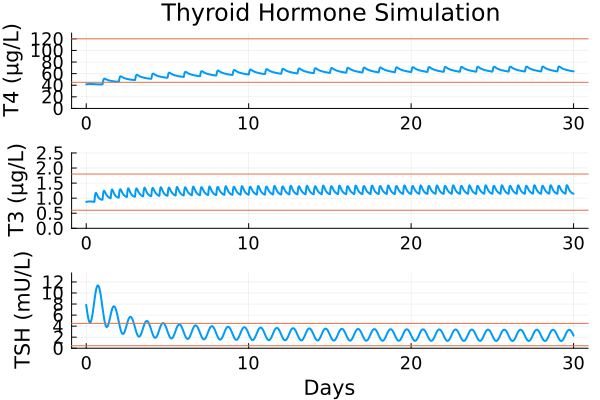

In [1769]:
# Example 3: Male, 77 in, 200 lbs, RTF = 15%, given LT4 dose of 112.5 µg every 24 hrs and 7.5 µg LT3 every 12 hours
# Plotted on TT4, TT3, TSH plots

# === INPUTS (Imperial units) ===
sex = true                  # true = Male, false = Female
h_in = 77                   # Height in inches
w_lb = 200                  # Weight in pounds
T4dose = 112.5                 # LT4 dose in µg
T3dose = 7.5                  # LT3 dose in µg
RTF = 0.15                   # Residual thyroid function (0–1)
dial = [RTF; 0.88; RTF; 0.88] # Thyroid secretion rates (stays constant)

# === Convert to metric units ===
h_m = inches_to_meters(h_in)
w_kg = pounds_to_kilograms(w_lb)

# === RUN SIMULATION ===
# 24-hr dosing intervals of LT4 + LT3
#sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose)

# 24-hr dosing interval of LT4 and 12-hr dosing interval of LT3
sol = simulate_dosing_intervals(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose) 


# === PLOT RESULTS ===
#plt = dosing_plots_FT4_FT3_TSH(sol, title="Thyroid Hormone Simulation") # Plots FT4, FT3, TSH
#plt = dosing_plots_FT4_TT3_TSH(sol, title="Thyroid Hormone Simulation") # Plots FT4, TT3, TSH
plt = dosing_plots_TT4_TT3_TSH(sol, title="Thyroid Hormone Simulation") # Plots TT4, TT3, TSH


# Generate RTF Raw Data

In [1610]:
using Printf


# === Helper function to simulate and extract hormone data at steady state ===
function extract_steady_state(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    T3 = sol[4, :]
    TSH = 5.6 * sol[7, :] / p[48]

    # Adjusted FT4 and FT3 formulas from your plotting function
    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    FT3 = 1.05 * 0.5 * (0.00395 .+ 0.00185 .* T4 .+ 0.00061 .* T4.^2 .+ 0.000505 .* T4.^3) .* T3

    FT4_units = 1000 * 777 .* FT4 ./ p[47]      # ng/L
    FT3_units = 1000 * 651 .* FT3 ./ p[47]      # ng/L
    TT3_units = 651.0 * T3 ./ p[47]             # µg/L

    return FT4_units[end], FT3_units[end], TT3_units[end], TSH[end]
end

# === Parameters for simulation ===
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
sex = true  # Male
T4dose = 0.0
T3dose = 0.0
h_in = 80
w_lb = 308

# Convert to metric
h_m = inches_to_meters(h_in)
w_kg = pounds_to_kilograms(w_lb)

# === Print header ===
println("RTF\tFT4 (ng/L)\tFT3 (ng/L)\tTT3 (µg/L)\tTSH (mU/L)")

# === Loop through RTFs and simulate ===
for RTF in rtfs
    dial = [RTF; 0.88; RTF; 0.88]
    sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose)

    ft4, ft3, tt3, tsh = extract_steady_state(sol)

    @printf("%.3f\t%.2f\t\t%.2f\t\t%.2f\t\t%.2f\n", RTF, ft4, ft3, tt3, tsh)
end


RTF	FT4 (ng/L)	FT3 (ng/L)	TT3 (µg/L)	TSH (mU/L)
0.000	0.00		0.00		0.00		1089.35
0.001	2.69		1.15		0.52		578.80
0.003	3.54		1.36		0.61		235.04
0.005	3.92		1.44		0.64		152.13
0.007	4.18		1.50		0.66		114.14
0.010	4.47		1.56		0.68		84.05
0.020	5.08		1.68		0.73		46.25
0.050	6.01		1.85		0.79		20.98
0.100	6.87		2.00		0.84		11.59
0.200	8.02		2.19		0.91		6.51
0.300	9.00		2.35		0.96		4.74
0.400	9.95		2.50		1.00		3.84
0.500	10.90		2.64		1.05		3.29
0.800	13.70		3.06		1.16		2.45
1.000	15.53		3.33		1.24		2.15


In [311]:
# Simulate Male FT4

using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract FT4 from solution
function extract_ft4(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    return 1000 * 777 .* FT4 ./ p[47]  # ng/L
end

# Parameters
h_in = 70
sex = true  # male
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
weights_lb = [100, 300]

# Store results in a dictionary keyed by RTF, value = tuple of FT4s at two weights
results = Dict{Float64, Tuple{Float64, Float64}}()

for rtf in rtfs
    ft4_vals = Float64[]
    for w_lb in weights_lb
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        dial = [rtf, 0.88, rtf, 0.88]
        sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=0.0, T3dose=0.0)
        ft4_day30 = extract_ft4(sol)[end]
        push!(ft4_vals, round(ft4_day30, digits=2))
    end
    results[rtf] = (ft4_vals[1], ft4_vals[2])
end

# Create DataFrame with columns: RTF, 100 lbs, 300 lbs
df = DataFrame(
    :RTF => rtfs,
    Symbol("100 lbs") => [results[r][1] for r in rtfs],
    Symbol("300 lbs") => [results[r][2] for r in rtfs]
)

# Write DataFrame to Excel
XLSX.writetable("/Users/Kat/Desktop/ft4_RTF_weight_final.xlsx", "FT4 Comparison" => df)


LoadError: AssertionError: /Users/Kat/Desktop/ft4_RTF_weight_final.xlsx already exists.

In [312]:
# Simulate Male FT3

using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract FT3 from solution
function extract_ft3(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    T3 = sol[4, :]
    FT3 = 1.05 * 0.5 * (0.00395 .+ 0.00185 .* T4 .+ 0.00061 .* T4.^2 .+ 0.000505 .* T4.^3) .* T3
    return 1000 * 651 .* FT3 ./ p[47]  # ng/L
end

# Parameters
h_in = 70
sex = true  # male
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
weights_lb = [100, 300]

# Store results in a dictionary keyed by RTF, value = tuple of FT3s at two weights
results = Dict{Float64, Tuple{Float64, Float64}}()

for rtf in rtfs
    ft3_vals = Float64[]
    for w_lb in weights_lb
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        dial = [rtf, 0.88, rtf, 0.88]
        sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=0.0, T3dose=0.0)
        ft3_day30 = extract_ft3(sol)[end]
        push!(ft3_vals, round(ft3_day30, digits=2))
    end
    results[rtf] = (ft3_vals[1], ft3_vals[2])
end

# Create DataFrame with columns: RTF, 100 lbs, 300 lbs
df = DataFrame(
    :RTF => rtfs,
    Symbol("100 lbs") => [results[r][1] for r in rtfs],
    Symbol("300 lbs") => [results[r][2] for r in rtfs]
)

# Write DataFrame to Excel
XLSX.writetable("/Users/Kat/Desktop/ft3_RTF_weight_comparison.xlsx", "FT3 Comparison" => df)


LoadError: AssertionError: /Users/Kat/Desktop/ft3_RTF_weight_comparison.xlsx already exists.

In [327]:
# Simulate Male TT3

using XLSX
using DataFrames

# Given data
rtfs = [0.000, 0.001, 0.003, 0.005, 0.007, 0.010, 0.020, 0.050, 0.100, 0.200, 0.300, 0.400, 0.500, 0.800, 1.000]

tt3_100lbs = [
    0.000184, 0.524655, 0.607831, 0.641023, 0.662372,
    0.684915, 0.729272, 0.790942, 0.842811, 0.906930,
    0.957458, 1.003425, 1.046733, 1.164723, 1.235086
]

tt3_300lbs = [
    0.000162, 0.524596, 0.607831, 0.641023, 0.662372,
    0.684915, 0.729272, 0.790941, 0.842811, 0.906928,
    0.957459, 1.003427, 1.046733, 1.164713, 1.235090
]

# Create DataFrame with simple column names
df = DataFrame(
    RTF = rtfs,
    TT3_100lbs = tt3_100lbs,
    TT3_300lbs = tt3_300lbs
)

# Rename columns to desired strings with spaces
rename!(df, Dict(
    :TT3_100lbs => "TT3 @ 100 lbs (µg/L)",
    :TT3_300lbs => "TT3 @ 300 lbs (µg/L)"
))

# Write to Excel
output_path = "/Users/Kat/Desktop/TT3_weight_comparison.xlsx"
XLSX.writetable(output_path, "TT3 Comparison" => df)

println("✅ Excel file created at: $output_path")


✅ Excel file created at: /Users/Kat/Desktop/TT3_weight_comparison.xlsx


In [328]:
# Simulate Male TSH
using XLSX
using DataFrames
using Statistics  # for log10

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract TSH from solution
function extract_tsh(sol)
    p = sol.prob.p
    TSH_raw = 5.6 * sol[7, :] ./ p[48]  # mU/L
    return TSH_raw
end

# Parameters
h_in = 70
sex = true  # male
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
weights_lb = [100, 300]

# Store results in a dictionary keyed by RTF, value = tuple of (TSH at 100, TSH at 300)
results = Dict{Float64, Tuple{Float64, Float64}}()

for rtf in rtfs
    tsh_vals = Float64[]
    for w_lb in weights_lb
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        dial = [rtf, 0.88, rtf, 0.88]
        sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=0.0, T3dose=0.0)
        tsh_day30 = extract_tsh(sol)[end]
        push!(tsh_vals, tsh_day30)
    end
    results[rtf] = (tsh_vals[1], tsh_vals[2])
end

# Prepare columns for DataFrame
tsh_100 = [results[r][1] for r in rtfs]
tsh_300 = [results[r][2] for r in rtfs]
log10_tsh_100 = log10.(tsh_100)
log10_tsh_300 = log10.(tsh_300)

# Create DataFrame with original TSH and log10(TSH) columns
df = DataFrame(
    :RTF => rtfs,
    Symbol("TSH @ 100 lbs (mU/L)") => tsh_100,
    Symbol("TSH @ 300 lbs (mU/L)") => tsh_300,
    Symbol("log10 TSH @ 100 lbs") => log10_tsh_100,
    Symbol("log10 TSH @ 300 lbs") => log10_tsh_300,
)

# Write DataFrame to Excel
XLSX.writetable("/Users/Kat/Desktop/tsh_RTF_weight_comparison.xlsx", "TSH Comparison" => df)

println("✅ Excel file with TSH and log10(TSH) saved.")


✅ Excel file with TSH and log10(TSH) saved.


In [329]:
# FEMALES

using Printf

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# === Helper function to simulate and extract hormone data at steady state ===
function extract_steady_state(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    T3 = sol[4, :]
    TSH = 5.6 * sol[7, :] / p[48]

    # Adjusted FT4 and FT3 formulas from your plotting function
    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    FT3 = 1.05 * 0.5 * (0.00395 .+ 0.00185 .* T4 .+ 0.00061 .* T4.^2 .+ 0.000505 .* T4.^3) .* T3

    FT4_units = 1000 * 777 .* FT4 ./ p[47]      # ng/L
    FT3_units = 1000 * 651 .* FT3 ./ p[47]      # ng/L
    TT3_units = 651.0 * T3 ./ p[47]             # µg/L

    return FT4_units[end], FT3_units[end], TT3_units[end], TSH[end]
end

# === Parameters for simulation ===
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
sex = false  # Female
T4dose = 0.0
T3dose = 0.0
h_in = 65
w_lb = 140

# Convert to metric
h_m = inches_to_meters(h_in)
w_kg = pounds_to_kilograms(w_lb)

# === Print header ===
println("RTF\tFT4 (ng/L)\tFT3 (ng/L)\tTT3 (µg/L)\tTSH (mU/L)")

# === Loop through RTFs and simulate ===
for RTF in rtfs
    dial = [RTF; 0.88; RTF; 0.88]
    sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose)

    ft4, ft3, tt3, tsh = extract_steady_state(sol)

    @printf("%.3f\t%.2f\t\t%.2f\t\t%.2f\t\t%.2f\n", RTF, ft4, ft3, tt3, tsh)
end


RTF	FT4 (ng/L)	FT3 (ng/L)	TT3 (µg/L)	TSH (mU/L)
0.000	0.00		0.00		0.00		873.58
0.001	2.54		1.17		0.55		460.37
0.003	3.30		1.36		0.63		186.97
0.005	3.64		1.45		0.67		121.06
0.007	3.87		1.50		0.69		90.82
0.010	4.13		1.55		0.71		66.88
0.020	4.65		1.66		0.76		36.81
0.050	5.43		1.82		0.83		16.70
0.100	6.14		1.95		0.88		9.23
0.200	7.07		2.12		0.95		5.19
0.300	7.85		2.26		1.00		3.78
0.400	8.59		2.38		1.05		3.06
0.500	9.30		2.50		1.09		2.62
0.800	11.38		2.84		1.22		1.95
1.000	12.68		3.04		1.29		1.72


In [332]:
# Simulate Female FT4

using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract FT4 from solution
function extract_ft4(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    return 1000 * 777 .* FT4 ./ p[47]  # ng/L
end

# Parameters for female
h_in = 65
sex = false  # female
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
weights_lb = [100, 300]

# Store results keyed by RTF, value = tuple(FT4 @ 100 lbs, FT4 @ 300 lbs)
results = Dict{Float64, Tuple{Float64, Float64}}()

for rtf in rtfs
    ft4_vals = Float64[]
    for w_lb in weights_lb
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        dial = [rtf, 0.88, rtf, 0.88]
        sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=0.0, T3dose=0.0)
        ft4_val = extract_ft4(sol)[end]
        push!(ft4_vals, round(ft4_val, digits=2))
    end
    results[rtf] = (ft4_vals[1], ft4_vals[2])
end

# Create DataFrame with columns: RTF, 100 lbs, 300 lbs
df = DataFrame(
    :RTF => rtfs,
    Symbol("100 lbs") => [results[r][1] for r in rtfs],
    Symbol("300 lbs") => [results[r][2] for r in rtfs]
)

# Write DataFrame to Excel
XLSX.writetable("/Users/Kat/Desktop/ft4_RTF_weight_female_65in.xlsx", "FT4 Comparison" => df)


In [333]:
# Simulate Female FT3

using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract FT3 from solution
function extract_ft3(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    T3 = sol[4, :]
    FT3 = 1.05 * 0.5 * (0.00395 .+ 0.00185 .* T4 .+ 0.00061 .* T4.^2 .+ 0.000505 .* T4.^3) .* T3
    return 1000 * 651 .* FT3 ./ p[47]  # ng/L
end

# Parameters for female
h_in = 65
sex = false  # female
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
weights_lb = [100, 300]

# Store results keyed by RTF, value = tuple(FT3 @ 100 lbs, FT3 @ 300 lbs)
results = Dict{Float64, Tuple{Float64, Float64}}()

for rtf in rtfs
    ft3_vals = Float64[]
    for w_lb in weights_lb
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        dial = [rtf, 0.88, rtf, 0.88]
        sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=0.0, T3dose=0.0)
        ft3_val = extract_ft3(sol)[end]
        push!(ft3_vals, round(ft3_val, digits=2))
    end
    results[rtf] = (ft3_vals[1], ft3_vals[2])
end

# Create DataFrame with columns: RTF, 100 lbs, 300 lbs
df = DataFrame(
    :RTF => rtfs,
    Symbol("100 lbs") => [results[r][1] for r in rtfs],
    Symbol("300 lbs") => [results[r][2] for r in rtfs]
)

# Write DataFrame to Excel
XLSX.writetable("/Users/Kat/Desktop/ft3_RTF_weight_female_65in.xlsx", "FT3 Comparison" => df)


In [334]:
# Simulate Female TT3
using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract TT3 from solution
function extract_tt3(sol)
    p = sol.prob.p
    T3 = sol[4, :]
    TT3 = 651.0 * T3 ./ p[47]  # µg/L
    return TT3
end

# Parameters for female
h_in = 65
sex = false  # female
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
weights_lb = [100, 300]

results = Dict{Float64, Tuple{Float64, Float64}}()

for rtf in rtfs
    tt3_vals = Float64[]
    for w_lb in weights_lb
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        dial = [rtf, 0.88, rtf, 0.88]
        sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=0.0, T3dose=0.0)
        tt3_val = extract_tt3(sol)[end]
        push!(tt3_vals, round(tt3_val, digits=6))
    end
    results[rtf] = (tt3_vals[1], tt3_vals[2])
end

df = DataFrame(
    :RTF => rtfs,
    Symbol("100 lbs") => [results[r][1] for r in rtfs],
    Symbol("300 lbs") => [results[r][2] for r in rtfs]
)

XLSX.writetable("/Users/Kat/Desktop/tt3_RTF_weight_female_65in.xlsx", "TT3 Comparison" => df)


In [335]:
# Simulate Female TSH

using XLSX
using DataFrames
using Statistics

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract TSH from solution
function extract_tsh(sol)
    p = sol.prob.p
    TSH = 5.6 * sol[7, :] ./ p[48]  # mU/L
    return TSH
end

# Parameters for female
h_in = 65
sex = false  # female
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
weights_lb = [100, 300]

results = Dict{Float64, Tuple{Float64, Float64, Float64, Float64}}()

for rtf in rtfs
    tsh_vals = Float64[]
    for w_lb in weights_lb
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        dial = [rtf, 0.88, rtf, 0.88]
        sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=0.0, T3dose=0.0)
        tsh_val = extract_tsh(sol)[end]
        push!(tsh_vals, tsh_val)
    end
    # Store (TSH_100, TSH_300, log10_TSH_100, log10_TSH_300)
    tsh_log_100 = tsh_vals[1] > 0 ? log10(tsh_vals[1]) : NaN
    tsh_log_300 = tsh_vals[2] > 0 ? log10(tsh_vals[2]) : NaN
    results[rtf] = (round(tsh_vals[1], digits=6), round(tsh_vals[2], digits=6), round(tsh_log_100, digits=6), round(tsh_log_300, digits=6))
end

df = DataFrame(
    :RTF => rtfs,
    Symbol("TSH @ 100 lbs (mU/L)") => [results[r][1] for r in rtfs],
    Symbol("TSH @ 300 lbs (mU/L)") => [results[r][2] for r in rtfs],
    Symbol("log10 TSH @ 100 lbs") => [results[r][3] for r in rtfs],
    Symbol("log10 TSH @ 300 lbs") => [results[r][4] for r in rtfs]
)

XLSX.writetable("/Users/Kat/Desktop/tsh_RTF_weight_log10_female_65in.xlsx", "TSH Comparison" => df)


# Official Simulation Code

In [389]:
# Male TT3
using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract TT3 from solution
function extract_tt3(sol)
    p = sol.prob.p
    T3 = sol[4, :]
    return 651.0 * T3 ./ p[47]  # µg/L
end

# RTF values to simulate
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Male height (in) and weight (lbs) combos
height_weight_pairs = [
    (60, 155),
    (65, 175),
    (70, 200),
    (75, 225),
    (80, 255)
]



# Prepare Excel file
XLSX.openxlsx("/Users/Kat/Desktop/male_tt3_rtf_output.xlsx", mode="w") do xf
    for (h_in, w_lb) in height_weight_pairs
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        tt3_vals = Float64[]

        for rtf in rtfs
            dial = [rtf, 0.88, rtf, 0.88]
            sol = simulate(h_m, w_kg, true, dial=dial, T4dose=0.0, T3dose=0.0)
            tt3 = extract_tt3(sol)[end]
            push!(tt3_vals, round(tt3, digits=6))
        end

        df = DataFrame(
            :RTF => rtfs,
            Symbol("TT3 (µg/L) at $(h_in)in, $(w_lb)lbs") => tt3_vals
        )

        sheet = XLSX.addsheet!(xf, "$(h_in)in_$(w_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ TT3 simulation for males completed and saved to Excel.")


✅ TT3 simulation for males completed and saved to Excel.


In [337]:
# Female TT3

using XLSX
using DataFrames

# --- Unit conversion helpers ---
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# --- Extract TT3 from solution ---
function extract_tt3(sol)
    p = sol.prob.p
    T3 = sol[4, :]
    return 651.0 * T3 ./ p[47]  # µg/L
end

# --- Parameters ---
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Female height (in) and weight (lbs) pairs
height_weight_pairs = [
    (55, 128),
    (60, 150),
    (65, 170),
    (70, 195),
    (75, 220)
]

# --- Output Excel file ---
XLSX.openxlsx("/Users/Kat/Desktop/female_tt3_rtf_output.xlsx", mode="w") do xf
    for (h_in, w_lb) in height_weight_pairs
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        tt3_vals = Float64[]

        for rtf in rtfs
            dial = [rtf, 0.88, rtf, 0.88]
            sol = simulate(h_m, w_kg, false, dial=dial, T4dose=0.0, T3dose=0.0)
            tt3 = extract_tt3(sol)[end]
            push!(tt3_vals, round(tt3, digits=6))
        end

        df = DataFrame(
            :RTF => rtfs,
            Symbol("TT3 (µg/L) at $(h_in)in, $(w_lb)lbs") => tt3_vals
        )

        sheet = XLSX.addsheet!(xf, "$(h_in)in_$(w_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ TT3 simulation for females completed and saved to Excel.")


✅ TT3 simulation for females completed and saved to Excel.


In [355]:
# Male FT4

using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract FT4 from solution
function extract_ft4(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    return 1000 * 777 .* FT4 ./ p[47]  # ng/L
end

# RTF values to simulate
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Male height (in) and weight (lbs) combos
height_weight_pairs = [
    (60, 100),
    (60, 155),
    (60, 210),
    (65, 110),
    (65, 175),
    (65, 240),
    (70, 120),
    (70, 200),
    (70, 280),
    (75, 130),
    (75, 225),
    (75, 320),
    (80, 150),
    (80, 255),
    (80, 360),
]

# Prepare Excel file
XLSX.openxlsx("/Users/Kat/Desktop/male_ft4_rtf_output.xlsx", mode="w") do xf
    for (h_in, w_lb) in height_weight_pairs
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        ft4_vals = Float64[]

        for rtf in rtfs
            dial = [rtf, 0.88, rtf, 0.88]
            sol = simulate(h_m, w_kg, true, dial=dial, T4dose=0.0, T3dose=0.0)
            ft4 = extract_ft4(sol)[end]
            push!(ft4_vals, round(ft4, digits=6))
        end

        df = DataFrame(
            :RTF => rtfs,
            Symbol("FT4 (ng/L) at $(h_in)in, $(w_lb)lbs") => ft4_vals
        )

        sheet = XLSX.addsheet!(xf, "$(h_in)in_$(w_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ FT4 simulation for males completed and saved to Excel.")


✅ FT4 simulation for males completed and saved to Excel.


In [357]:
# Female FT4
using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract FT4 from solution
function extract_ft4(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    return 1000 * 777 .* FT4 ./ p[47]  # ng/L
end

# RTF values to simulate
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Female height (in) and weight (lbs) combos
height_weight_pairs = [
    (55, 90),
    (55, 128),
    (55, 170),
    (60, 90),
    (60, 150),
    (60, 210),
    (65, 100),
    (65, 170),
    (65, 240),
    (70, 110),
    (70, 195),
    (70, 280),
    (75, 120),
    (75, 220),
    (75, 320)
]

# Prepare Excel file
XLSX.openxlsx("/Users/Kat/Desktop/female_ft4_rtf_output.xlsx", mode="w") do xf
    for (h_in, w_lb) in height_weight_pairs
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        ft4_vals = Float64[]

        for rtf in rtfs
            dial = [rtf, 0.88, rtf, 0.88]
            sol = simulate(h_m, w_kg, false, dial=dial, T4dose=0.0, T3dose=0.0)  # sex = false for female
            ft4 = extract_ft4(sol)[end]
            push!(ft4_vals, round(ft4, digits=6))
        end

        df = DataFrame(
            :RTF => rtfs,
            Symbol("FT4 (ng/L) at $(h_in)in, $(w_lb)lbs") => ft4_vals
        )

        sheet = XLSX.addsheet!(xf, "$(h_in)in_$(w_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ FT4 simulation for females completed and saved to Excel.")


✅ FT4 simulation for females completed and saved to Excel.


In [358]:
# Male FT3

using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract FT3 from solution
function extract_ft3(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    T3 = sol[4, :]
    FT3 = 1.05 * 0.5 * (0.00395 .+ 0.00185 .* T4 .+ 0.00061 .* T4.^2 .+ 0.000505 .* T4.^3) .* T3
    return 1000 * 651 .* FT3 ./ p[47]  # ng/L
end

# RTF values to simulate
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Male height (in) and weight (lbs) combos
height_weight_pairs = [
    (60, 100),
    (60, 155),
    (60, 210),
    (65, 110),
    (65, 175),
    (65, 240),
    (70, 120),
    (70, 200),
    (70, 280),
    (75, 130),
    (75, 225),
    (75, 320),
    (80, 150),
    (80, 255),
    (80, 360),
]

# Prepare Excel file
XLSX.openxlsx("/Users/Kat/Desktop/male_ft3_rtf_output.xlsx", mode="w") do xf
    for (h_in, w_lb) in height_weight_pairs
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        ft3_vals = Float64[]

        for rtf in rtfs
            dial = [rtf, 0.88, rtf, 0.88]
            sol = simulate(h_m, w_kg, true, dial=dial, T4dose=0.0, T3dose=0.0)
            ft3 = extract_ft3(sol)[end]
            push!(ft3_vals, round(ft3, digits=6))
        end

        df = DataFrame(
            :RTF => rtfs,
            Symbol("FT3 (ng/L) at $(h_in)in, $(w_lb)lbs") => ft3_vals
        )

        sheet = XLSX.addsheet!(xf, "$(h_in)in_$(w_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ FT3 simulation for males completed and saved to Excel.")


✅ FT3 simulation for males completed and saved to Excel.


In [359]:
# Female FT3

using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract FT3 from solution
function extract_ft3(sol)
    p = sol.prob.p
    T4 = sol[1, :]
    T3 = sol[4, :]
    FT3 = 1.05 * 0.5 * (0.00395 .+ 0.00185 .* T4 .+ 0.00061 .* T4.^2 .+ 0.000505 .* T4.^3) .* T3
    return 1000 * 651 .* FT3 ./ p[47]  # ng/L
end

# RTF values to simulate
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Female height (in) and weight (lbs) combos
height_weight_pairs = [
    (55, 90),
    (55, 128),
    (55, 170),
    (60, 90),
    (60, 150),
    (60, 210),
    (65, 100),
    (65, 170),
    (65, 240),
    (70, 110),
    (70, 195),
    (70, 280),
    (75, 120),
    (75, 220),
    (75, 320)
]

# Prepare Excel file
XLSX.openxlsx("/Users/Kat/Desktop/female_ft3_rtf_output.xlsx", mode="w") do xf
    for (h_in, w_lb) in height_weight_pairs
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)
        ft3_vals = Float64[]

        for rtf in rtfs
            dial = [rtf, 0.88, rtf, 0.88]
            sol = simulate(h_m, w_kg, false, dial=dial, T4dose=0.0, T3dose=0.0)  # sex = false for female
            ft3 = extract_ft3(sol)[end]
            push!(ft3_vals, round(ft3, digits=6))
        end

        df = DataFrame(
            :RTF => rtfs,
            Symbol("FT3 (ng/L) at $(h_in)in, $(w_lb)lbs") => ft3_vals
        )

        sheet = XLSX.addsheet!(xf, "$(h_in)in_$(w_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ FT3 simulation for females completed and saved to Excel.")


✅ FT3 simulation for females completed and saved to Excel.


In [360]:
# Male TSH

using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract TSH from solution
function extract_tsh(sol)
    p = sol.prob.p
    TSH = 5.6 * sol[7, :] ./ p[48]
    return TSH
end

# RTF values
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Male height/weight pairs
height_weight_pairs = [
    (60, 100), (60, 155), (60, 210),
    (65, 110), (65, 175), (65, 240),
    (70, 120), (70, 200), (70, 280),
    (75, 130), (75, 225), (75, 320),
    (80, 150), (80, 255), (80, 360)
]

# Write to Excel
XLSX.openxlsx("/Users/Kat/Desktop/male_tsh_log10_output.xlsx", mode="w") do xf
    for (h_in, w_lb) in height_weight_pairs
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)

        tsh_vals = Float64[]
        log_tsh_vals = Float64[]

        for rtf in rtfs
            dial = [rtf, 0.88, rtf, 0.88]
            sol = simulate(h_m, w_kg, true, dial=dial, T4dose=0.0, T3dose=0.0)
            tsh = extract_tsh(sol)[end]
            push!(tsh_vals, round(tsh, digits=6))
            push!(log_tsh_vals, round(log10(tsh), digits=6))
        end

        df = DataFrame(
            :RTF => rtfs,
            Symbol("TSH (mU/L) at $(h_in)in, $(w_lb)lbs") => tsh_vals,
            Symbol("log10(TSH) at $(h_in)in, $(w_lb)lbs") => log_tsh_vals
        )

        sheet = XLSX.addsheet!(xf, "$(h_in)in_$(w_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ Male TSH + log10(TSH) complete.")


✅ Male TSH + log10(TSH) complete.


In [361]:
# Female TSH

using XLSX
using DataFrames

# Unit conversions
inches_to_meters(h_in) = h_in * 0.0254
pounds_to_kilograms(w_lb) = w_lb * 0.453592

# Extract TSH from solution
function extract_tsh(sol)
    p = sol.prob.p
    TSH = 5.6 * sol[7, :] ./ p[48]
    return TSH
end

# RTF values
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Female height/weight pairs
height_weight_pairs = [
    (55, 90), (55, 128), (55, 170),
    (60, 90), (60, 150), (60, 210),
    (65, 100), (65, 170), (65, 240),
    (70, 110), (70, 195), (70, 280),
    (75, 120), (75, 220), (75, 320)
]

# Write to Excel
XLSX.openxlsx("/Users/Kat/Desktop/female_tsh_log10_output.xlsx", mode="w") do xf
    for (h_in, w_lb) in height_weight_pairs
        h_m = inches_to_meters(h_in)
        w_kg = pounds_to_kilograms(w_lb)

        tsh_vals = Float64[]
        log_tsh_vals = Float64[]

        for rtf in rtfs
            dial = [rtf, 0.88, rtf, 0.88]
            sol = simulate(h_m, w_kg, false, dial=dial, T4dose=0.0, T3dose=0.0)
            tsh = extract_tsh(sol)[end]
            push!(tsh_vals, round(tsh, digits=6))
            push!(log_tsh_vals, round(log10(tsh), digits=6))
        end

        df = DataFrame(
            :RTF => rtfs,
            Symbol("TSH (mU/L) at $(h_in)in, $(w_lb)lbs") => tsh_vals,
            Symbol("log10(TSH) at $(h_in)in, $(w_lb)lbs") => log_tsh_vals
        )

        sheet = XLSX.addsheet!(xf, "$(h_in)in_$(w_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ Female TSH + log10(TSH) complete.")


✅ Female TSH + log10(TSH) complete.


# Scratch Work

In [348]:
using XLSX
using DataFrames

rtfs = [0.0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
tt3_60_in_200_lb = [0.8160, 0.8267, 0.8378, 0.8439, 0.8477, 0.8528, 0.8647, 0.8907, 0.9151, 0.9521, 0.9783, 1.0019, 1.0237, 1.0904, 1.1363]
tt3_80_in_200_lb = [0.8158, 0.8264, 0.8374, 0.8434, 0.8473, 0.8524, 0.8642, 0.8901, 0.9145, 0.9514, 0.9776, 1.0011, 1.0229, 1.0895, 1.1354]

df = DataFrame(
    RTF = rtfs,
    TT3_60_in_200_lb = tt3_60_in_200_lb,
    TT3_80_in_200_lb = tt3_80_in_200_lb
)

filename = "/Users/Kat/Desktop/male_tt3_200lbs_60_80in.xlsx"


XLSX.writetable(filename, "TT3 Comparison" => Tables.columntable(df))

println("Excel file saved as $filename")


Excel file saved as /Users/Kat/Desktop/male_tt3_200lbs_60_80in.xlsx


In [277]:
# Load necessary packages for simulation, plotting, and data handling
using Revise
using Plots
using CSV
using DataFrames

# Relative Thyroid Function (RTF) scaling factors for simulation (dimensionless)
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Sex variable for simulation: true = male, false = female
sex = true

# Set T4 and T3 doses to zero to simulate endogenous hormone production only
T4dose = 0.0
T3dose = 0.0

0.0

In [316]:
# Simulate TT3

using XLSX
using DataFrames

# Define constants & parameters
male = true  # true = male, false = female

rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
T4dose = 0.0  # no dose to simulate endogenous

# Heights in meters
heights_m = Dict(
    "60in" => 1.524,
    "65in" => 1.651,
    "70in" => 1.778,
    "75in" => 1.905,
    "80in" => 2.032,
)

# Weight range pounds and converted kg
weights_lb = 100:10:370
weights_kg = [lb * 0.453592 for lb in weights_lb]

# Output file path
output_filename = "/Users/Kat/Desktop/T3_Male_Weights.xlsx"

# Run simulations and export
XLSX.openxlsx(output_filename, mode="w") do xf
    for (i, weight_kg) in enumerate(weights_kg)
        weight_lb = weights_lb[i]
        println("🔬 Simulating for weight: $(weight_lb) lbs")

        # Dictionary to store TT3 vectors for each height
        tt3_data = Dict{String, Vector{Float64}}()

        for (label, height) in heights_m
            tt3_values = Float64[]

            for rtf in rtfs
                dial = [rtf, 0.88, rtf, 0.88]
                sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

                vp = sol.prob.p[47]   # Plasma volume
                tt3 = 651.0 * sol[4, :] / vp

                push!(tt3_values, tt3[end])
            end

            tt3_data[label] = tt3_values
        end

        # Create DataFrame with RTF + one column per height
        df = DataFrame(RTF = rtfs)
        for (label, values) in tt3_data
            df[!, label] = values
        end

        # Add sheet and write data frame
        sheetname = "$(weight_lb)lbs"
        XLSX.addsheet!(xf, sheetname)
        XLSX.writetable!(xf[sheetname], df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All simulations completed and exported to $(output_filename)")


🔬 Simulating for weight: 100 lbs
🔬 Simulating for weight: 110 lbs
🔬 Simulating for weight: 120 lbs
🔬 Simulating for weight: 130 lbs
🔬 Simulating for weight: 140 lbs


LoadError: InterruptException:

In [283]:
using XLSX
using DataFrames

# Define subject characteristics
male = true  # true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    "60in" => 1.524,
    "65in" => 1.651,
    "70in" => 1.778,
    "75in" => 1.905,
    "80in" => 2.032,
)

# Define weight range in pounds and convert to kg
weights_lb = 100:10:370
weights_kg = [lb * 0.453592 for lb in weights_lb]

# Prepare Excel file path
output_filename = "/Users/Kat/Desktop/FT3_Male_Weights.xlsx"

# Run simulations and export to Excel
XLSX.openxlsx(output_filename, mode="w") do xf
    for (i, weight_kg) in enumerate(weights_kg)
        weight_lb = weights_lb[i]
        println("🔬 Simulating for weight: $(weight_lb) lbs")

        # Storage for FT3 values across heights
        ft3_data = Dict{String, Vector{Float64}}()

        for (label, height) in heights_m
            ft3_data[label] = Float64[]

            for rtf in rtfs
                dial = [rtf, 0.88, rtf, 0.88]
                sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

                # Extract final T3 and T4 from simulation
                T3 = sol[4, end]
                T4 = sol[2, end]

                # Calculate FT3 using the provided formula
                ft3 = 1.05 * 0.5 * (0.00395 + 0.00185 * T4 + 0.00061 * T4^2 + 0.000505 * T4^3) * T3

                push!(ft3_data[label], ft3)
            end
        end

        # Create DataFrame for this weight
        df = DataFrame("RTF" => rtfs)
        for (label, values) in ft3_data
            df[!, label] = values
        end

        # Create a new sheet and write the DataFrame to it
        sheet = XLSX.addsheet!(xf, "$(weight_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All FT3 simulations completed and exported to $(output_filename)")


🔬 Simulating for weight: 100 lbs
🔬 Simulating for weight: 110 lbs
🔬 Simulating for weight: 120 lbs
🔬 Simulating for weight: 130 lbs
🔬 Simulating for weight: 140 lbs
🔬 Simulating for weight: 150 lbs
🔬 Simulating for weight: 160 lbs
🔬 Simulating for weight: 170 lbs
🔬 Simulating for weight: 180 lbs
🔬 Simulating for weight: 190 lbs
🔬 Simulating for weight: 200 lbs
🔬 Simulating for weight: 210 lbs
🔬 Simulating for weight: 220 lbs
🔬 Simulating for weight: 230 lbs
🔬 Simulating for weight: 240 lbs
🔬 Simulating for weight: 250 lbs
🔬 Simulating for weight: 260 lbs
🔬 Simulating for weight: 270 lbs
🔬 Simulating for weight: 280 lbs
🔬 Simulating for weight: 290 lbs
🔬 Simulating for weight: 300 lbs
🔬 Simulating for weight: 310 lbs
🔬 Simulating for weight: 320 lbs
🔬 Simulating for weight: 330 lbs
🔬 Simulating for weight: 340 lbs
🔬 Simulating for weight: 350 lbs
🔬 Simulating for weight: 360 lbs
🔬 Simulating for weight: 370 lbs
✅ All FT3 simulations completed and exported to /Users/Kat/Desktop/FT3_Male_

In [281]:
# Simulate FT3

using XLSX
using DataFrames

# Define subject characteristics
male = true  # true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    60 => 1.524,
    65 => 1.651,
    70 => 1.778,
    75 => 1.905,
    80 => 2.032,
)

# List of specific (height, weight) combinations in inches and lbs
combinations = [
    (60, 100),
    (60, 160),
    (60, 230),
    (65, 100),
    (65, 190),
    (65, 270),
    (70, 100),
    (70, 200),
    (70, 300),
    (75, 120),
    (75, 230),
    (75, 350),
    (80, 130),
    (80, 240),
    (80, 360),
]

# Prepare Excel file path
output_filename = "/Users/Kat/Desktop/FT3_Male_SelectedWeights.xlsx"

# Run simulations and export to Excel
XLSX.openxlsx(output_filename, mode="w") do xf
    for (height_in, weight_lb) in combinations
        println("🔬 Simulating for height: $(height_in) in, weight: $(weight_lb) lbs")

        height_m = heights_m[height_in]
        weight_kg = weight_lb * 0.453592

        # Storage for FT3 values across RTFs
        ft3_values = Float64[]

        for rtf in rtfs
            dial = [rtf, 0.88, rtf, 0.88]
            sol = simulate(height_m, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

            # Get final T3 and T4 from simulation
            T3 = sol[4, end]
            T4 = sol[2, end]

            # Compute FT3 using provided formula
            FT3 = 1.05 * 0.5 * (0.00395 + 0.00185*T4 + 0.00061*T4^2 + 0.000505*T4^3) * T3
            push!(ft3_values, FT3)
        end

        # Create DataFrame and write to a new sheet
        df = DataFrame("RTF" => rtfs, "FT3" => ft3_values)
        sheet_name = "$(height_in)in_$(weight_lb)lbs"
        sheet = XLSX.addsheet!(xf, sheet_name)
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All FT3 simulations completed and exported to $(output_filename)")

🔬 Simulating for height: 60 in, weight: 100 lbs
🔬 Simulating for height: 60 in, weight: 160 lbs
🔬 Simulating for height: 60 in, weight: 230 lbs
🔬 Simulating for height: 65 in, weight: 100 lbs
🔬 Simulating for height: 65 in, weight: 190 lbs
🔬 Simulating for height: 65 in, weight: 270 lbs
🔬 Simulating for height: 70 in, weight: 100 lbs
🔬 Simulating for height: 70 in, weight: 200 lbs
🔬 Simulating for height: 70 in, weight: 300 lbs
🔬 Simulating for height: 75 in, weight: 120 lbs
🔬 Simulating for height: 75 in, weight: 230 lbs
🔬 Simulating for height: 75 in, weight: 350 lbs
🔬 Simulating for height: 80 in, weight: 130 lbs
🔬 Simulating for height: 80 in, weight: 240 lbs
🔬 Simulating for height: 80 in, weight: 360 lbs
✅ All FT3 simulations completed and exported to /Users/Kat/Desktop/FT3_Male_SelectedWeights.xlsx


In [284]:
# Simulate FT4
using XLSX
using DataFrames

# Define subject characteristics
male = true  # true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    "60in" => 1.524,
    "65in" => 1.651,
    "70in" => 1.778,
    "75in" => 1.905,
    "80in" => 2.032,
)

# Define weight range in pounds and convert to kg
weights_lb = 100:10:370
weights_kg = [lb * 0.453592 for lb in weights_lb]

# Prepare Excel file path
output_filename = "/Users/Kat/Desktop/FT4_Male_Weights.xlsx"

# Run simulations and export to Excel
XLSX.openxlsx(output_filename, mode="w") do xf
    for (i, weight_kg) in enumerate(weights_kg)
        weight_lb = weights_lb[i]
        println("🔬 Simulating for weight: $(weight_lb) lbs")

        # Storage for FT4 values across heights
        ft4_data = Dict{String, Vector{Float64}}()

        for (label, height) in heights_m
            ft4_data[label] = Float64[]

            for rtf in rtfs
                dial = [rtf, 0.88, rtf, 0.88]
                sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

                # Extract final T4 from simulation
                T4 = sol[2, end]

                # Calculate FT4 using the provided formula
                ft4 = 1.1 * 0.45 * (0.000289 + 0.000214 * T4 + 0.000128 * T4^2 - 8.83e-6 * T4^3) * T4

                push!(ft4_data[label], ft4)
            end
        end

        # Create DataFrame for this weight
        df = DataFrame("RTF" => rtfs)
        for (label, values) in ft4_data
            df[!, label] = values
        end

        # Create a new sheet and write the DataFrame to it
        sheet = XLSX.addsheet!(xf, "$(weight_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All FT4 simulations completed and exported to $(output_filename)")



🔬 Simulating for weight: 100 lbs
🔬 Simulating for weight: 110 lbs
🔬 Simulating for weight: 120 lbs
🔬 Simulating for weight: 130 lbs
🔬 Simulating for weight: 140 lbs
🔬 Simulating for weight: 150 lbs
🔬 Simulating for weight: 160 lbs
🔬 Simulating for weight: 170 lbs
🔬 Simulating for weight: 180 lbs
🔬 Simulating for weight: 190 lbs
🔬 Simulating for weight: 200 lbs
🔬 Simulating for weight: 210 lbs
🔬 Simulating for weight: 220 lbs
🔬 Simulating for weight: 230 lbs
🔬 Simulating for weight: 240 lbs
🔬 Simulating for weight: 250 lbs
🔬 Simulating for weight: 260 lbs
🔬 Simulating for weight: 270 lbs
🔬 Simulating for weight: 280 lbs
🔬 Simulating for weight: 290 lbs
🔬 Simulating for weight: 300 lbs
🔬 Simulating for weight: 310 lbs
🔬 Simulating for weight: 320 lbs
🔬 Simulating for weight: 330 lbs
🔬 Simulating for weight: 340 lbs
🔬 Simulating for weight: 350 lbs
🔬 Simulating for weight: 360 lbs
🔬 Simulating for weight: 370 lbs
✅ All FT4 simulations completed and exported to /Users/Kat/Desktop/FT4_Male_

In [285]:
using XLSX
using DataFrames

# Define subject characteristics
male = true  # true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    "60in" => 1.524,
    "65in" => 1.651,
    "70in" => 1.778,
    "75in" => 1.905,
    "80in" => 2.032,
)

# Define weight range in pounds and convert to kg
weights_lb = 100:10:370
weights_kg = [lb * 0.453592 for lb in weights_lb]

# Output file path
output_filename = "/Users/Kat/Desktop/TSH_Male_Weights.xlsx"

# Run simulations and export to Excel
XLSX.openxlsx(output_filename, mode="w") do xf
    for (i, weight_kg) in enumerate(weights_kg)
        weight_lb = weights_lb[i]
        println("🔬 Simulating for weight: $(weight_lb) lbs")

        # Storage for TSH values per height
        tsh_data = Dict{String, Vector{Float64}}()

        for (label, height) in heights_m
            tsh_data[label] = Float64[]

            for rtf in rtfs
                dial = [rtf, 0.88, rtf, 0.88]
                sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

                vp = sol.prob.p[47]  # Plasma volume
                vt = sol.prob.p[48]  # Thyrotroph mass

                tsh = 5.6 * sol[7, end] / vt

                push!(tsh_data[label], tsh)
            end
        end

        # Create DataFrame for this weight
        df = DataFrame("RTF" => rtfs)
        for (label, values) in tsh_data
            df[!, label] = values
        end

        # Write to a new Excel sheet
        sheet = XLSX.addsheet!(xf, "$(weight_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All TSH simulations completed and exported to $(output_filename)")


🔬 Simulating for weight: 100 lbs
🔬 Simulating for weight: 110 lbs
🔬 Simulating for weight: 120 lbs
🔬 Simulating for weight: 130 lbs
🔬 Simulating for weight: 140 lbs
🔬 Simulating for weight: 150 lbs
🔬 Simulating for weight: 160 lbs
🔬 Simulating for weight: 170 lbs
🔬 Simulating for weight: 180 lbs
🔬 Simulating for weight: 190 lbs
🔬 Simulating for weight: 200 lbs
🔬 Simulating for weight: 210 lbs
🔬 Simulating for weight: 220 lbs
🔬 Simulating for weight: 230 lbs
🔬 Simulating for weight: 240 lbs
🔬 Simulating for weight: 250 lbs
🔬 Simulating for weight: 260 lbs
🔬 Simulating for weight: 270 lbs
🔬 Simulating for weight: 280 lbs
🔬 Simulating for weight: 290 lbs
🔬 Simulating for weight: 300 lbs
🔬 Simulating for weight: 310 lbs
🔬 Simulating for weight: 320 lbs
🔬 Simulating for weight: 330 lbs
🔬 Simulating for weight: 340 lbs
🔬 Simulating for weight: 350 lbs
🔬 Simulating for weight: 360 lbs
🔬 Simulating for weight: 370 lbs
✅ All TSH simulations completed and exported to /Users/Kat/Desktop/TSH_Male_

In [287]:
# simulate tt3

using XLSX
using DataFrames

# Define subject characteristics
male = true  # true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    "60in" => 1.524,
    "65in" => 1.651,
    "70in" => 1.778,
    "75in" => 1.905,
    "80in" => 2.032,
)

# Define weight range in pounds and convert to kg
weights_lb = 100:10:370
weights_kg = [lb * 0.453592 for lb in weights_lb]

# Output file path
output_filename = "/Users/Kat/Desktop/TT3_Male_Weights.xlsx"

# Run simulations and export to Excel
XLSX.openxlsx(output_filename, mode="w") do xf
    for (i, weight_kg) in enumerate(weights_kg)
        weight_lb = weights_lb[i]
        println("🔬 Simulating for weight: $(weight_lb) lbs")

        # Storage for TT3 values per height
        tt3_data = Dict{String, Vector{Float64}}()

        for (label, height) in heights_m
            tt3_data[label] = Float64[]

            for rtf in rtfs
                dial = [rtf, 0.88, rtf, 0.88]
                sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

                vp = sol.prob.p[47]  # Plasma volume

                # TT3 = scaled T3 concentration / plasma volume
                tt3 = 651.0 * sol[4, end] / vp

                push!(tt3_data[label], tt3)
            end
        end

        # Create DataFrame for this weight
        df = DataFrame("RTF" => rtfs)
        for (label, values) in tt3_data
            df[!, label] = values
        end

        # Write to a new Excel sheet
        sheet = XLSX.addsheet!(xf, "$(weight_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All TT3 simulations completed and exported to $(output_filename)")


🔬 Simulating for weight: 100 lbs
🔬 Simulating for weight: 110 lbs
🔬 Simulating for weight: 120 lbs
🔬 Simulating for weight: 130 lbs
🔬 Simulating for weight: 140 lbs
🔬 Simulating for weight: 150 lbs
🔬 Simulating for weight: 160 lbs
🔬 Simulating for weight: 170 lbs
🔬 Simulating for weight: 180 lbs
🔬 Simulating for weight: 190 lbs
🔬 Simulating for weight: 200 lbs
🔬 Simulating for weight: 210 lbs
🔬 Simulating for weight: 220 lbs
🔬 Simulating for weight: 230 lbs
🔬 Simulating for weight: 240 lbs
🔬 Simulating for weight: 250 lbs
🔬 Simulating for weight: 260 lbs
🔬 Simulating for weight: 270 lbs
🔬 Simulating for weight: 280 lbs
🔬 Simulating for weight: 290 lbs
🔬 Simulating for weight: 300 lbs
🔬 Simulating for weight: 310 lbs
🔬 Simulating for weight: 320 lbs
🔬 Simulating for weight: 330 lbs
🔬 Simulating for weight: 340 lbs
🔬 Simulating for weight: 350 lbs
🔬 Simulating for weight: 360 lbs
🔬 Simulating for weight: 370 lbs
✅ All TT3 simulations completed and exported to /Users/Kat/Desktop/TT3_Male_

In [291]:
# Load necessary packages for simulation, plotting, and data handling
using Revise
using Plots
using CSV
using DataFrames

# Use GR backend for plotting and set PNG format for output
gr(fmt=:png)

# Set global font sizes for better plot readability
default(titlefontsize=16, guidefontsize=14, tickfontsize=12)



#FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
#FT3 = 1.05 * 0.5 * (0.00395 .+ 0.00185 .* T4 .+ 0.00061 .* T4.^2 .+ 0.000505 .* T4.^3) .* T3 



"""
Convert total triiodothyronine (TT3, μmol) and total thyroxine (TT4, μmol) to free T3 (FT3, μmol)
using Thyrosim’s 4th order polynomial model.
"""
function FT3(TT4::Float64, TT3::Float64)
    return (0.00395 + (0.00185 * TT4) + (0.000610 * TT4^2) - (0.000505 * TT4^3)) * TT3 * 1.05 * 0.5
end

"""
Convert total thyroxine (TT4, μmol) to free T4 (FT4, μmol)
using Thyrosim’s 4th order polynomial model.
"""
function FT4(TT4::Float64)
    return (0.000289 + (0.000214 * TT4) + (0.000128 * TT4^2) - (8.83e-6 * TT4^3)) * TT4 * 1.1 * 0.45
end

"""
Convert total thyroxine (TT4, μmol, Thyrosim output q1) to free T4 (FT4) concentration in ng/L,
adjusting for plasma volume (Vp).
"""
function TT4_to_FT4(TT4::Float64, Vp::Float64)
    return FT4(TT4) * 777 / Vp * 1000 * 0.45
end

"""
Convert total triiodothyronine (TT3, μmol) and total thyroxine (TT4, μmol) to free T3 (FT3) concentration in ng/L,
adjusting for plasma volume (Vp).
"""
function TT3_to_FT3(TT4::Float64, TT3::Float64, Vp::Float64)
    return FT3(TT4, TT3) * 651 / Vp * 1000 * 0.50
end

# Notify user that conversion functions are loaded and ready to use
println("Thyrosim conversion functions loaded successfully.")

Thyrosim conversion functions loaded successfully.


In [292]:
# Relative Thyroid Function (RTF) scaling factors for simulation (dimensionless)
rtfs = [0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]

# Sex variable for simulation: true = male, false = female
sex = true

# Set T4 and T3 doses to zero to simulate endogenous hormone production only
T4dose = 0.0
T3dose = 0.0

0.0

In [296]:
# Define subject characteristics
weight_kg = 45.3592  # 100 lbs
male = true             # sex: true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    "60in" => 1.524,
    "63in" => 1.6002,
    "66in" => 1.6764,
    "69in" => 1.7526,
    "72in" => 1.8288,
    "75in" => 1.905,
    "78in" => 1.9812,
    "81in" => 2.0574,
)

# Storage dictionaries for results
results = Dict{String, Dict{String, Vector{Float64}}}()

for (label, height) in heights_m
    # Initialize storage vectors for each hormone output
    results[label] = Dict(
        "TSH" => Float64[],
        "FT3" => Float64[],
        "FT4" => Float64[],
        "TT3" => Float64[],
        "TT4" => Float64[], 
    )

    for rtf in rtfs
        dial = [rtf, 0.88, rtf, 0.88]
        sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

        vp = sol.prob.p[47]   # Plasma volume
        vt = sol.prob.p[48]   # Thyrotroph mass?

        # Raw simulated values
        tt4 = 777.0 * sol[1, :] / vp
        tt3 = 651.0 * sol[4, :] / vp
        ft4 = TT4_to_FT4.(sol[1, :], vp)
        ft3 = TT3_to_FT3.(sol[1, :], sol[4, :], vp)
        tsh = 5.6 * sol[7, :] / vt

        # Push final steady-state values
        push!(results[label]["TT4"], tt4[end])
        push!(results[label]["TT3"], tt3[end])
        push!(results[label]["FT4"], ft4[end])
        push!(results[label]["FT3"], ft3[end])
        push!(results[label]["TSH"], tsh[end])
    end
end

println("Simulations completed for 230 lb male at 5 different heights.")

Simulations completed for 230 lb male at 5 different heights.


In [297]:
using XLSX
using DataFrames

# Example: Export TSH data for male of 100 lb

# Create a DataFrame for TSH values at each height
example_data = DataFrame(
    "RTF" => rtfs,
    "60 in" => results["60in"]["FT4"],
    "63 in" => results["63in"]["FT4"],
    "66 in" => results["66in"]["FT4"],
    "69 in" => results["69in"]["FT4"],
    "72 in" => results["72in"]["FT4"],
    "75 in" => results["75in"]["FT4"],
    "78 in" => results["78in"]["FT4"],
    "81 in" => results["81in"]["FT4"],
)

# Save Excel file to Desktop
output_filename = "/Users/Kat/Desktop/FT4_Male_100lbs_3.xlsx"
XLSX.writetable(output_filename, example_data)
println("✅ Data exported to $(output_filename)")

✅ Data exported to /Users/Kat/Desktop/FT4_Male_100lbs_3.xlsx


In [92]:
using XLSX
using DataFrames

# Define subject characteristics
male = true  # true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    "60in" => 1.524,
    "63in" => 1.6002,
    "66in" => 1.6764,
    "69in" => 1.7526,
    "72in" => 1.8288,
    "75in" => 1.905,
    "78in" => 1.9812,
    "81in" => 2.0574,
)

# Define weight range in pounds and convert to kg
weights_lb = 110:10:370
weights_kg = [lb * 0.453592 for lb in weights_lb]

# Prepare Excel file path
output_filename = "/Users/Kat/Desktop/TT3_Male_Weights.xlsx"

# Run simulations and export to Excel
XLSX.openxlsx(output_filename, mode="w") do xf
    for (i, weight_kg) in enumerate(weights_kg)
        weight_lb = weights_lb[i]
        println("🔬 Simulating for weight: $(weight_lb) lbs")

        # Storage for TT3 values across heights
        tt3_data = Dict{String, Vector{Float64}}()

        for (label, height) in heights_m
            tt3_data[label] = Float64[]

            for rtf in rtfs
                dial = [rtf, 0.88, rtf, 0.88]
                sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

                vp = sol.prob.p[47]   # Plasma volume
                tt3 = 651.0 * sol[4, :] / vp

                push!(tt3_data[label], tt3[end])
            end
        end

        # Create DataFrame for this weight
        df = DataFrame("RTF" => rtfs)
        for (label, values) in tt3_data
            df[!, label] = values
        end

        # Create a new sheet and write the DataFrame to it
        sheet = XLSX.addsheet!(xf, "$(weight_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All simulations completed and exported to $(output_filename)")


🔬 Simulating for weight: 110 lbs
🔬 Simulating for weight: 120 lbs
🔬 Simulating for weight: 130 lbs
🔬 Simulating for weight: 140 lbs
🔬 Simulating for weight: 150 lbs
🔬 Simulating for weight: 160 lbs
🔬 Simulating for weight: 170 lbs
🔬 Simulating for weight: 180 lbs
🔬 Simulating for weight: 190 lbs
🔬 Simulating for weight: 200 lbs
🔬 Simulating for weight: 210 lbs
🔬 Simulating for weight: 220 lbs
🔬 Simulating for weight: 230 lbs
🔬 Simulating for weight: 240 lbs
🔬 Simulating for weight: 250 lbs
🔬 Simulating for weight: 260 lbs
🔬 Simulating for weight: 270 lbs
🔬 Simulating for weight: 280 lbs
🔬 Simulating for weight: 290 lbs
🔬 Simulating for weight: 300 lbs
🔬 Simulating for weight: 310 lbs
🔬 Simulating for weight: 320 lbs
🔬 Simulating for weight: 330 lbs
🔬 Simulating for weight: 340 lbs
🔬 Simulating for weight: 350 lbs
🔬 Simulating for weight: 360 lbs
🔬 Simulating for weight: 370 lbs
✅ All simulations completed and exported to /Users/Kat/Desktop/TT3_Male_Weights.xlsx


In [ ]:
using XLSX
using DataFrames

# Define subject characteristics
male = true  # true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    "60in" => 1.524,
    "63in" => 1.6002,
    "66in" => 1.6764,
    "69in" => 1.7526,
    "72in" => 1.8288,
    "75in" => 1.905,
    "78in" => 1.9812,
    "81in" => 2.0574,
)

# Define weight range in pounds and convert to kg
weights_lb = 110:10:370
weights_kg = [lb * 0.453592 for lb in weights_lb]

# Prepare Excel file path
output_filename = "/Users/Kat/Desktop/FT3_Male_Weights.xlsx"

# Run simulations and export to Excel
XLSX.openxlsx(output_filename, mode="w") do xf
    for (i, weight_kg) in enumerate(weights_kg)
        weight_lb = weights_lb[i]
        println("🔬 Simulating for weight: $(weight_lb) lbs")

        # Storage for FT3 values across heights
        ft3_data = Dict{String, Vector{Float64}}()

        for (label, height) in heights_m
            ft3_data[label] = Float64[]

            for rtf in rtfs
                dial = [rtf, 0.88, rtf, 0.88]
                sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

                vp = sol.prob.p[47]   # Plasma volume
                ft3 = TT3_to_FT3(sol[1, :], sol[4, :], vp)

                push!(ft3_data[label], ft3[end])
            end
        end

        # Create DataFrame for this weight
        df = DataFrame("RTF" => rtfs)
        for (label, values) in ft3_data
            df[!, label] = values
        end

        # Create a new sheet and write the DataFrame to it
        sheet = XLSX.addsheet!(xf, "$(weight_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All FT3 simulations completed and exported to $(output_filename)")


In [9]:
using XLSX
using DataFrames

# Define subject characteristics
male = true  # true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    "60in" => 1.524,
    "63in" => 1.6002,
    "66in" => 1.6764,
    "69in" => 1.7526,
    "72in" => 1.8288,
    "75in" => 1.905,
    "78in" => 1.9812,
    "81in" => 2.0574,
)

# Define weight range in pounds and convert to kg
weights_lb = 110:10:370
weights_kg = [lb * 0.453592 for lb in weights_lb]

# Prepare Excel file path
output_filename = "/Users/Kat/Desktop/FT4_Male_Weights.xlsx"

# Run simulations and export to Excel
XLSX.openxlsx(output_filename, mode="w") do xf
    for (i, weight_kg) in enumerate(weights_kg)
        weight_lb = weights_lb[i]
        println("🔬 Simulating for weight: $(weight_lb) lbs")

        # Storage for FT4 values across heights
        ft4_data = Dict{String, Vector{Float64}}()

        for (label, height) in heights_m
            ft4_data[label] = Float64[]

            for rtf in rtfs
                dial = [rtf, 0.88, rtf, 0.88]
                sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

                vp = sol.prob.p[47]   # Plasma volume
                ft4 = TT4_to_FT4(sol[1, :], vp)

                push!(ft4_data[label], ft4[end])
            end
        end

        # Create DataFrame for this weight
        df = DataFrame("RTF" => rtfs)
        for (label, values) in ft4_data
            df[!, label] = values
        end

        # Create a new sheet and write the DataFrame to it
        sheet = XLSX.addsheet!(xf, "$(weight_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All FT4 simulations completed and exported to $(output_filename)")


🔬 Simulating for weight: 110 lbs


LoadError: MethodError: no method matching TT4_to_FT4(::Vector{Float64}, ::Float64)
The function `TT4_to_FT4` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  TT4_to_FT4([91m::Float64[39m, ::Float64)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[7]:33[24m[39m


In [35]:
using XLSX
using DataFrames

# Define subject characteristics
male = true  # true = male, false = female

# Heights in inches converted to meters
heights_m = Dict(
    "60in" => 1.524,
    "63in" => 1.6002,
    "66in" => 1.6764,
    "69in" => 1.7526,
    "72in" => 1.8288,
    "75in" => 1.905,
    "78in" => 1.9812,
    "81in" => 2.0574,
)

# Define weight range in pounds and convert to kg
weights_lb = 110:10:370
weights_kg = [lb * 0.453592 for lb in weights_lb]

# Prepare Excel file path
output_filename = "/Users/Kat/Desktop/FT4_Male_Weights.xlsx"

# Run simulations and export to Excel
XLSX.openxlsx(output_filename, mode="w") do xf
    for (i, weight_kg) in enumerate(weights_kg)
        weight_lb = weights_lb[i]
        println("🔬 Simulating for weight: $(weight_lb) lbs")

        # Storage for FT4 values across heights
        ft4_data = Dict{String, Vector{Float64}}()

        for (label, height) in heights_m
            ft4_data[label] = Float64[]

            for rtf in rtfs
                dial = [rtf, 0.88, rtf, 0.88]
                sol = simulate(height, weight_kg, male, days=50, dial=dial, T4dose=T4dose, warmup=true)

                vp = sol.prob.p[47]           # Plasma volume
                tt4 = sol[1, :]               # TT4 (q1 from Thyrosim)
                ft4 = TT4_to_FT4(tt4[end], vp)

                push!(ft4_data[label], ft4)
            end
        end

        # Create DataFrame for this weight
        df = DataFrame("RTF" => rtfs)
        for (label, values) in ft4_data
            df[!, label] = values
        end

        # Create a new sheet and write the DataFrame to it
        sheet = XLSX.addsheet!(xf, "$(weight_lb)lbs")
        XLSX.writetable!(sheet, df; anchor_cell=XLSX.CellRef("A1"), write_columnnames=true)
    end
end

println("✅ All FT4 simulations completed and exported to $(output_filename)")


🔬 Simulating for weight: 110 lbs
🔬 Simulating for weight: 120 lbs
🔬 Simulating for weight: 130 lbs
🔬 Simulating for weight: 140 lbs
🔬 Simulating for weight: 150 lbs
🔬 Simulating for weight: 160 lbs
🔬 Simulating for weight: 170 lbs
🔬 Simulating for weight: 180 lbs
🔬 Simulating for weight: 190 lbs
🔬 Simulating for weight: 200 lbs
🔬 Simulating for weight: 210 lbs
🔬 Simulating for weight: 220 lbs
🔬 Simulating for weight: 230 lbs
🔬 Simulating for weight: 240 lbs
🔬 Simulating for weight: 250 lbs
🔬 Simulating for weight: 260 lbs
🔬 Simulating for weight: 270 lbs
🔬 Simulating for weight: 280 lbs
🔬 Simulating for weight: 290 lbs
🔬 Simulating for weight: 300 lbs
🔬 Simulating for weight: 310 lbs
🔬 Simulating for weight: 320 lbs
🔬 Simulating for weight: 330 lbs
🔬 Simulating for weight: 340 lbs
🔬 Simulating for weight: 350 lbs
🔬 Simulating for weight: 360 lbs
🔬 Simulating for weight: 370 lbs
✅ All FT4 simulations completed and exported to /Users/Kat/Desktop/FT4_Male_Weights.xlsx
